## META TGI

In [ ]:
!pip install -U sagemaker transformers sentencepiece
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

In [ ]:
%pip install --upgrade  sagemaker

In [2]:
import os
import time
from sagemaker.huggingface import get_huggingface_llm_image_uri
import boto3
import json
from sagemaker.huggingface import HuggingFaceModel
import argparse
import yaml
import sagemaker
import pandas as pd
import json
from sagemaker.jumpstart.model import JumpStartModel
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mixtral-8x7B-v0.1")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [5]:
model_id = "huggingface-llm-mixtral-8x7b-instruct"
# model_version = "3.*"

In [ ]:
from sagemaker.jumpstart.model import JumpStartModel
endpoint_name_mixtral=f"{model_id}-{str(time.time()).split('.')[-1]}"
config = {                                
                "MAX_CONCURRENT_REQUESTS":"500" # Ceiling for number of concurrent request
            }
model = JumpStartModel(model_id=model_id, env=config)
llm = model.deploy(accept_eula=True, 
                         initial_instance_count=1,
                         instance_type="ml.g5.48xlarge",
                        endpoint_name=endpoint_name_mixtral,
                               wait=False,   )

In [13]:
model_id = "meta-textgeneration-llama-2-13b-f"
model_version = "3.*"
endpoint_name_llama=f"{model_id}-{str(time.time()).split('.')[-1]}"
config = {                                
                "MAX_CONCURRENT_REQUESTS":"500" # Ceiling for number of concurrent request
            }

model = JumpStartModel(model_id=model_id, model_version=model_version, env=config)
llm = model.deploy(accept_eula=True, 
                         initial_instance_count=1,
                         instance_type="ml.g5.12xlarge",
                        endpoint_name=endpoint_name_llama,
                               wait=False,   )


Using model 'meta-textgeneration-llama-2-13b-f' with wildcard version identifier '3.*'. You can pin to version '3.0.2' for more stable results. Note that models may have different input/output signatures after a major version upgrade.


In [6]:
#quantized Llama2-13
model_id="TheBloke/Llama-2-13B-chat-AWQ"
config = {
    "HF_MODEL_ID": model_id,  # model_id from hf.co/models
    "SM_NUM_GPUS": json.dumps(1),  # Number of GPU used per replica
    "MAX_INPUT_LENGTH": json.dumps(4095),  # Max length of input text
    "MAX_TOTAL_TOKENS": json.dumps(4096),  # Max length of the generation (including input text)
     "HUGGING_FACE_HUB_TOKEN": "HF TOKEN",
    "HF_MODEL_QUANTIZE" : "awq",
    "MAX_CONCURRENT_REQUESTS":"500" # Ceiling for number of concurrent request

}
llm_image = get_huggingface_llm_image_uri("huggingface", version="1.3.3")
llm_model = HuggingFaceModel(role=sagemaker.get_execution_role(), image_uri=llm_image, env=config)
endpoint_name_llama_q=f"{model_id.split('/')[-1]}-{str(time.time()).split('.')[-1]}"
llm = llm_model.deploy(accept_eula=True, 
                         initial_instance_count=1,
                         instance_type="ml.g5.2xlarge",
                        endpoint_name=endpoint_name_llama_q,
                               wait=False,   )

In [22]:
## Initialize sagemaker endpoint
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer
predictor=Predictor(endpoint_name=endpoint_name_mixtral,
                    serializer=JSONSerializer(),                    
    deserializer=JSONDeserializer(),
                   )

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [3]:
import boto3
import concurrent.futures
import time

In [4]:
with open(f"prompt/rag_1000.txt","r")as f: 
    prompt=f.read()
# Number of input tokens
tok=tokenizer.encode(prompt, return_tensors="pt")[0]
len(tok)

1000

# RAG USAGE PATTERN

A RAG (Retrieval Augmented Generation) pattern typically involves a large input token size (200 - 500+) and a relatively low output token size (100-200)

In [12]:
num_parallel_requests = 90  #Number of concurrent users 
results_holder={}

# Different RAG patterns. The dictionary key is the prompt token size and the values are corresponding output token limits
holder={"rag_1000":[50,100,150,200],
        "rag_500":[50,100,150,200],
        "rag_250":[50,100,150,200]
              }
for item in holder:
    results_holder[item]={}
    with open(f"prompt/{item}.txt","r")as f: # different prompt template of various token size stored in local
        prompt=f.read()
    for output_token_len in holder[item]:
        def send_request(prompt):
            time_now=time.time()
            response=predictor.predict({"inputs": prompt,
                              "parameters": {
                    "max_new_tokens": output_token_len,
                    # "top_p": 0.9,
                    # "temperature": 0.6,
                    "return_full_text": False,
                }})
            time_later=time.time()
            diff=time_later-time_now
            return diff

        # Create a ThreadPoolExecutor for parallel execution
        with concurrent.futures.ThreadPoolExecutor(max_workers=num_parallel_requests) as executor:
            # Submit parallel requests
            futures = [executor.submit(send_request, prompt) for _ in range(num_parallel_requests)]

            # Wait for all requests to complete
            concurrent.futures.wait(futures)

            # Get the results from completed requests
            results = [future.result() for future in futures]
        results_holder[item][output_token_len]=results


In [15]:
max_inference_time=60 # The maximum time threshold for sagemaker realtime inference in seconds
ideal_concurrency=[100,500,1000] # number of concurrent users that would be making a single call to the endpoint simultaneously in production


dataframe_list=[]
for concurrency in ideal_concurrency:
    data_holder={"prompt_size":[],
             "output_token_length":[],
             "number_of_instances":[],
             }
    for prompt_size in results_holder:
        for token_length in results_holder[prompt_size]:
            request_latencies=results_holder[prompt_size][token_length]
            avg_request_latency=sum(request_latencies)/len(request_latencies) # average time it took to complete the request for a given usage style combination
            normalized_concurrency_factor=max_inference_time/avg_request_latency # normalized average request latency time to 60secs which is the threshold timeout for sagemaker realtime inference

            # the number of instances required to meet the ideal concurrent users. This is calculated by
            # dividing the ideal concurrent users by the number of concurrent users that would max the sagemaker inference response timeout threshold (60s)
            number_of_instances_needed=concurrency/(normalized_concurrency_factor*num_parallel_requests) 
            data_holder["prompt_size"].append(prompt_size.split('_')[-1])
            data_holder["output_token_length"].append(token_length)
            data_holder["number_of_instances"].append(max(1,round(number_of_instances_needed)))        

    df = pd.DataFrame(data_holder)
    pricing_per_instance = 20.36 # Price per hour for the ml.g5.48xlarge instance. More pricing info at https://aws.amazon.com/sagemaker/pricing/
    # Calculate total pricing for each row  
    df['Hourly Pricing'] = df['number_of_instances'] * pricing_per_instance
    # df['Daily Pricing'] = df['Hourly Pricing'] * 24
    dataframe_list.append(df)

In [16]:
for ids, item in enumerate(dataframe_list):
    print(f'Capacity Sizing for {ideal_concurrency[ids]} concurrent users\n{item}\n')

Capacity Sizing for 100 concurrent users
   prompt_size  output_token_length  number_of_instances  Hourly Pricing
0         1000                   50                    1           20.36
1         1000                  100                    1           20.36
2         1000                  150                    1           20.36
3         1000                  200                    1           20.36
4          500                   50                    1           20.36
5          500                  100                    1           20.36
6          500                  150                    1           20.36
7          500                  200                    1           20.36
8          250                   50                    1           20.36
9          250                  100                    1           20.36
10         250                  150                    1           20.36
11         250                  200                    1           20.36

Capacity 

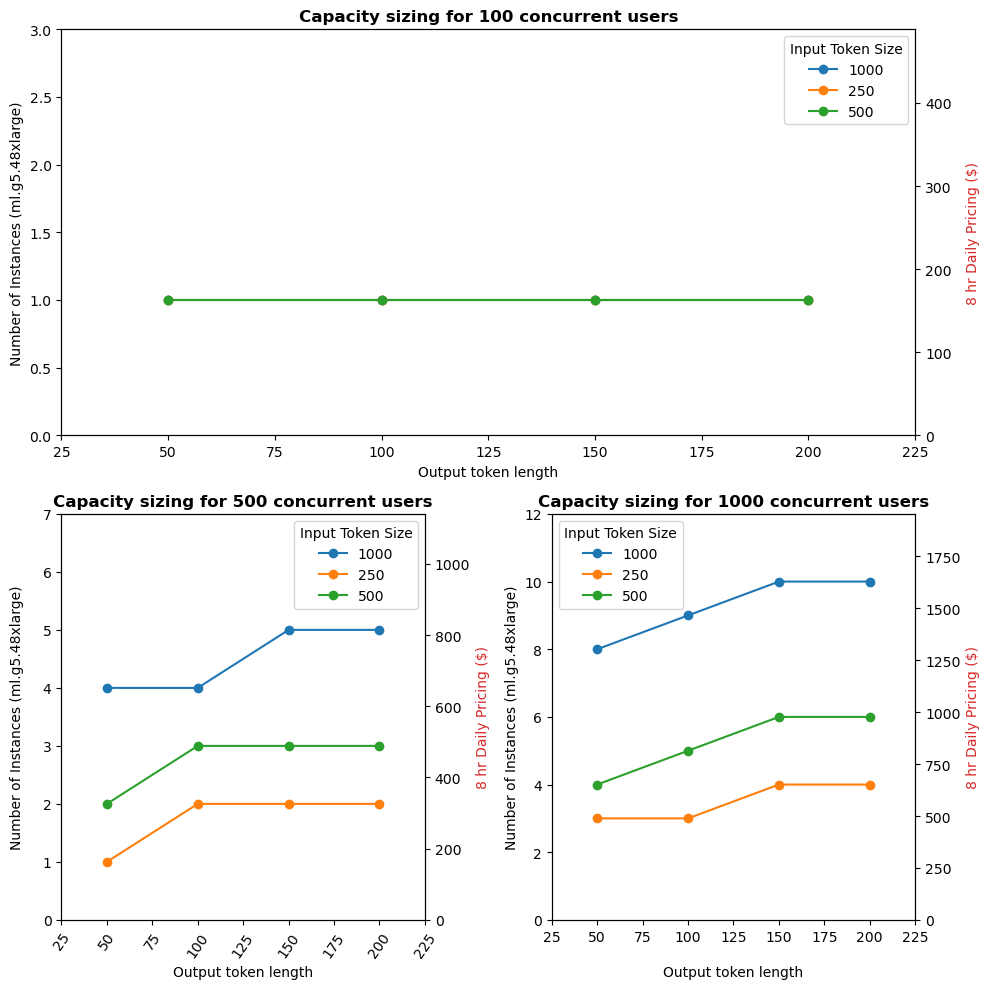

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
# plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(2, 2)

# ax = fig.add_subplot(gs[0, :])
ax = fig.add_subplot(gs[0, :])
ax2 = ax.twinx()
df=dataframe_list[0]
running_hours=8 ## number of hours endpoint would be up and running daily 
for key, group in df.groupby('prompt_size'):  
    ax.plot(group['output_token_length'], group['number_of_instances'], marker='o', label=key)
ax.legend(title='Input Token Size')  
ax.set_xlabel('Output token length')
ax.set_ylabel('Number of Instances (ml.g5.48xlarge)')
plt.title(f'Capacity sizing for {ideal_concurrency[0]} concurrent users',fontweight='bold')
ax.set_xlim(25, 225) 
ax.set_ylim(0, max(df['number_of_instances'])+2) 
color = 'tab:red'
ax2.set_ylabel(f'{running_hours} hr Daily Pricing ($)', color=color) 
ymin, ymax = ax.get_ylim() 
ax2.set_ylim(0, ymax*pricing_per_instance*running_hours) 
for i in range(2):
    ax = fig.add_subplot(gs[1, i])
    df=dataframe_list[i+1]
    ax2 = ax.twinx()
    for key, group in df.groupby('prompt_size'):  
        ax.plot(group['output_token_length'], group['number_of_instances'], marker='o', label=key)
        ax.legend(title='Input Token Size')  
        ax.set_xlabel('Output token length')
        ax.set_ylabel('Number of Instances (ml.g5.48xlarge)')
        plt.title(f'Capacity sizing for {ideal_concurrency[i+1]} concurrent users',fontweight='bold')
        ax.set_xlim(25, 225) 
        ax.set_ylim(0, max(df['number_of_instances'])+2) 
        color = 'tab:red'
        ax2.set_ylabel(f'{running_hours} hr Daily Pricing ($)', color=color)
        ymin, ymax = ax.get_ylim() 
        ax2.set_ylim(0, ymax*pricing_per_instance*running_hours)
        if i == 0:
                for tick in ax.get_xticklabels():
                    tick.set_rotation(55)
fig.align_labels() 
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

# Content Generation Usage Pattern

In Content Generation use case, the typical pattern is a small token input prompt (<50 tokens) and generally larger output token length

In [23]:

results_holder2={}

# Different Content Generation payload patterns
token_length=[250, 500,750,1000]

## Tested concurrent limits for the different token output length under 60s
token_length_concurrency_mapping={250:225,
                                  500:115,
                                  750:60,
                                  1000:30}
# Input token is generally small
prompt="""<<SYS>>You are my helpful and obedient assistant that writes books for me. <</SYS>>
[INST]Write a lengthy biography about Alexander The Great. Go very in detail and be comprehensive and touch on every area of his life.[/INST]"""

tok=tokenizer.encode(prompt, return_tensors="pt")[0]
print(f"Token length of prompt {len(tok)}")

for output_token_len in token_length:
    def send_request(prompt):
        time_now=time.time()
        response=predictor.predict({"inputs": prompt,
                          "parameters": {
                "max_new_tokens": output_token_len,
                # "top_p": 0.9,
                # "temperature": 0.6,
                "return_full_text": False,
            }})
        time_later=time.time()
        diff=time_later-time_now
        return diff

    # Create a ThreadPoolExecutor for parallel execution
    with concurrent.futures.ThreadPoolExecutor(max_workers=token_length_concurrency_mapping[output_token_len]) as executor:
        # Submit parallel requests
        futures = [executor.submit(send_request, prompt) for _ in range(token_length_concurrency_mapping[output_token_len])]

        # Wait for all requests to complete
        concurrent.futures.wait(futures)

        # Get the results from completed requests
        results = [future.result() for future in futures]
    results_holder2[output_token_len]=results


In [39]:
max_inference_time=60 # The maximum time threshold for realtime inference in seconds
ideal_concurrency=[100,500,1000] # number of concurrent users that would be making a single call to the endpoint simultaneously in production

dataframe_list=[]
for concurrency in ideal_concurrency:
    data_holder={
             "output_token_length":[],
             "number_of_instances":[],
             }
    for token_length in results_holder2:    
        request_latencies=results_holder2[token_length]
        avg_request_latency=sum(request_latencies)/len(request_latencies) # average time it took to complete the request for a given usage style pattern
        normalized_concurrency_factor=max_inference_time/avg_request_latency # normalized request latency time to 60secs which is the threshold timeout for sagemaker realtime inference

        # there number of instances required to meet the ideal concurrent users. This is calculated by
        # dividing the ideal concurrent users by the number of concurreny that would max the sagemaker inference timeout threshold (60s)
        number_of_instances_needed=concurrency/(normalized_concurrency_factor*len(request_latencies)) 
        # print(token_length,avg_request_latency,normalized_concurrency, len(request_latencies),number_of_instances_needed)

        data_holder["output_token_length"].append(token_length)
        data_holder["number_of_instances"].append(max(1,round(number_of_instances_needed)))        

    df = pd.DataFrame(data_holder)
    pricing_per_instance = 20.36 # Price per hour for the ml.g5.48xlarge instance. More pricing info at https://aws.amazon.com/sagemaker/pricing/
    # Calculate total pricing for each row  
    running_hours=8 ## number of hours endpoint would be up and running daily 
    df['Hourly Pricing'] = df['number_of_instances'] * pricing_per_instance
    df[f'{running_hours} hours Pricing'] = df['Hourly Pricing'] * running_hours
    dataframe_list.append(df)

In [40]:
for ids, item in enumerate(dataframe_list):
    print(f'Capacity Sizing for {ideal_concurrency[ids]} concurrent users\n{item}\n')

Capacity Sizing for 100 concurrent users
   output_token_length  number_of_instances  Hourly Pricing  8 hours Pricing
0                  250                    1           20.36           162.88
1                  500                    1           20.36           162.88
2                  750                    2           40.72           325.76
3                 1000                    3           61.08           488.64

Capacity Sizing for 500 concurrent users
   output_token_length  number_of_instances  Hourly Pricing  8 hours Pricing
0                  250                    2           40.72           325.76
1                  500                    4           81.44           651.52
2                  750                    8          162.88          1303.04
3                 1000                   16          325.76          2606.08

Capacity Sizing for 1000 concurrent users
   output_token_length  number_of_instances  Hourly Pricing  8 hours Pricing
0                  250     

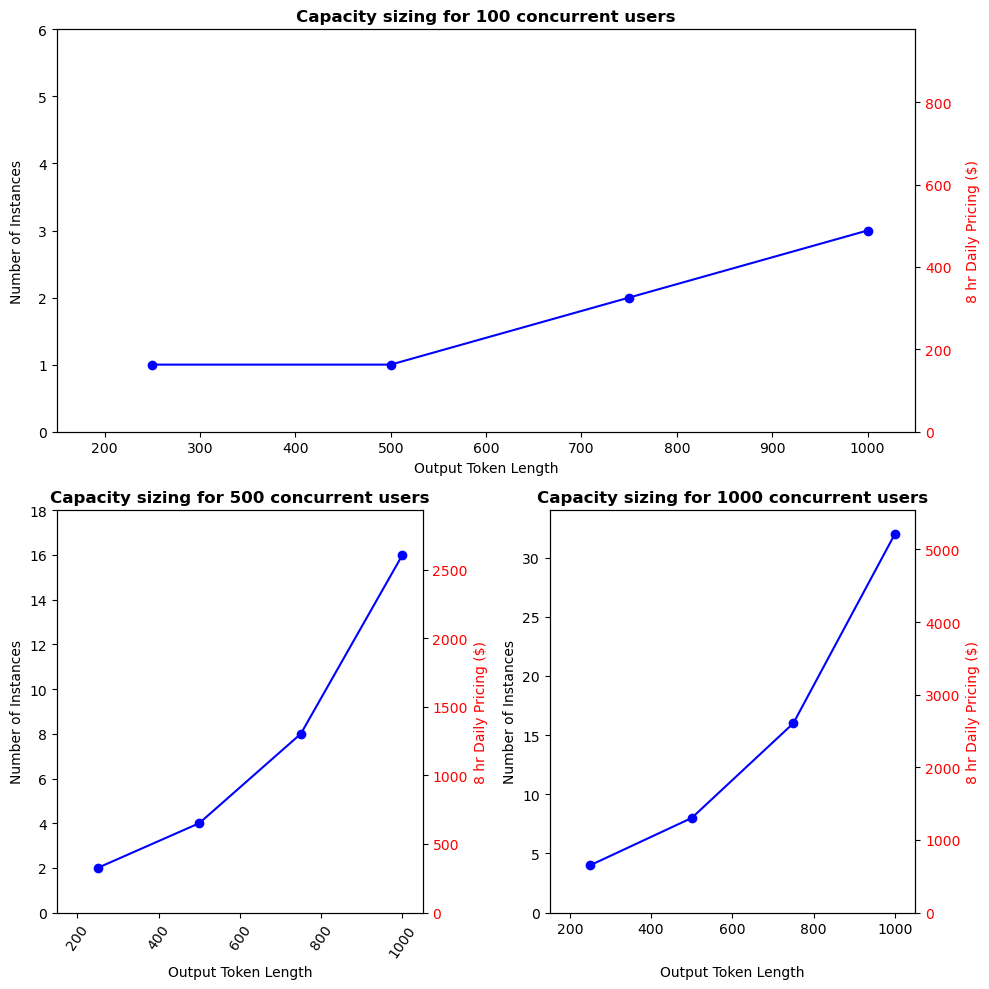

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
# plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(2, 2)

running_hours=8 ## number of hours endpoint would be up and running daily 

ax = fig.add_subplot(gs[0, :])
ax2 = ax.twinx()
df=dataframe_list[0]
ax.plot(df.output_token_length, df.number_of_instances, 'bo-')
ax.set_xlabel('Output Token Length')
ax.set_ylabel('Number of Instances')
ax.set_ylim(0, max(df['number_of_instances'])+3) 
ax.set_xlim(150, max(df.output_token_length)+50) 
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylabel(f'{running_hours} hr Daily Pricing ($)', color='r')
ymin, ymax = ax.get_ylim() 
ax2.set_ylim(0, ymax*pricing_per_instance*running_hours)
plt.title(f'Capacity sizing for {ideal_concurrency[0]} concurrent users',fontweight='bold')
for i in range(2):
    ax = fig.add_subplot(gs[1, i])
    df=dataframe_list[i+1]
    ax2 = ax.twinx()
    ax.plot(df.output_token_length, df.number_of_instances, 'bo-')
    ax.set_xlabel('Output Token Length')
    ax.set_ylabel('Number of Instances')
    ax.set_ylim(0, max(df['number_of_instances'])+2) 
    ax.set_xlim(150, max(df.output_token_length)+50) 
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.set_ylabel(f'{running_hours} hr Daily Pricing ($)', color='r')
    ymin, ymax = ax.get_ylim() 
    ax2.set_ylim(0, ymax*pricing_per_instance*running_hours)
    plt.title(f'Capacity sizing for {ideal_concurrency[i+1]} concurrent users',fontweight='bold')
    if i == 0:
        for tick in ax.get_xticklabels():
            tick.set_rotation(55)
fig.align_labels()  # same as fig.align_xlabels(); fig.align_ylabels()
plt.rcParams["figure.figsize"] = (10,10)
plt.show()


# LLama 2 13B Unquantized

In [14]:
## Initialize sagemaker endpoint
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer
predictor=Predictor(endpoint_name=endpoint_name_llama,
                    serializer=JSONSerializer(),                    
    deserializer=JSONDeserializer(),
                   )

### RAG USAGE PATTERN

In [8]:
num_parallel_requests = 70  #Number of concurrent users 
results_holder={}

# Different RAG patterns. The dictionary key is the prompt token size and the values are corresponding output token limits
holder={"rag_1000":[50,100,150,200],
        "rag_500":[50,100,150,200],
        "rag_250":[50,100,150,200]
              }
for item in holder:
    results_holder[item]={}
    with open(f"prompt/{item}.txt","r")as f: # different prompt template of various token size stored in local
        prompt=f.read()
    for output_token_len in holder[item]:
        def send_request(prompt):
            time_now=time.time()
            response=predictor.predict({"inputs": prompt,
                              "parameters": {
                    "max_new_tokens": output_token_len,
                    # "top_p": 0.9,
                    # "temperature": 0.6,
                    "return_full_text": False,
                }})
            time_later=time.time()
            diff=time_later-time_now
            return diff

        # Create a ThreadPoolExecutor for parallel execution
        with concurrent.futures.ThreadPoolExecutor(max_workers=num_parallel_requests) as executor:
            # Submit parallel requests
            futures = [executor.submit(send_request, prompt) for _ in range(num_parallel_requests)]

            # Wait for all requests to complete
            concurrent.futures.wait(futures)

            # Get the results from completed requests
            results = [future.result() for future in futures]
        results_holder[item][output_token_len]=results


In [9]:
max_inference_time=60 # The maximum time threshold for sagemaker realtime inference in seconds
ideal_concurrency=[100,500,1000] # number of concurrent users that would be making a single call to the endpoint simultaneously in production


dataframe_list=[]
for concurrency in ideal_concurrency:
    data_holder={"prompt_size":[],
             "output_token_length":[],
             "number_of_instances":[],
             }
    for prompt_size in results_holder:
        for token_length in results_holder[prompt_size]:
            request_latencies=results_holder[prompt_size][token_length]
            avg_request_latency=sum(request_latencies)/len(request_latencies) # average time it took to complete the request for a given usage style combination
            normalized_concurrency_factor=max_inference_time/avg_request_latency # normalized average request latency time to 60secs which is the threshold timeout for sagemaker realtime inference

            # the number of instances required to meet the ideal concurrent users. This is calculated by
            # dividing the ideal concurrent users by the number of concurrent users that would max the sagemaker inference response timeout threshold (60s)
            number_of_instances_needed=concurrency/(normalized_concurrency_factor*num_parallel_requests) 
            data_holder["prompt_size"].append(prompt_size.split('_')[-1])
            data_holder["output_token_length"].append(token_length)
            data_holder["number_of_instances"].append(max(1,round(number_of_instances_needed)))        

    df = pd.DataFrame(data_holder)
    pricing_per_instance = 7.09 # Price per hour for the ml.g5.12xlarge instance. More pricing info at https://aws.amazon.com/sagemaker/pricing/
    # Calculate total pricing for each row  
    df['Hourly Pricing'] = df['number_of_instances'] * pricing_per_instance
    # df['Daily Pricing'] = df['Hourly Pricing'] * 24
    dataframe_list.append(df)

In [10]:
for ids, item in enumerate(dataframe_list):
    print(f'Capacity Sizing for {ideal_concurrency[ids]} concurrent users\n{item}\n')

Capacity Sizing for 100 concurrent users
   prompt_size  output_token_length  number_of_instances  Hourly Pricing
0         1000                   50                    1            7.09
1         1000                  100                    1            7.09
2         1000                  150                    1            7.09
3         1000                  200                    1            7.09
4          500                   50                    1            7.09
5          500                  100                    1            7.09
6          500                  150                    1            7.09
7          500                  200                    1            7.09
8          250                   50                    1            7.09
9          250                  100                    1            7.09
10         250                  150                    1            7.09
11         250                  200                    1            7.09

Capacity 

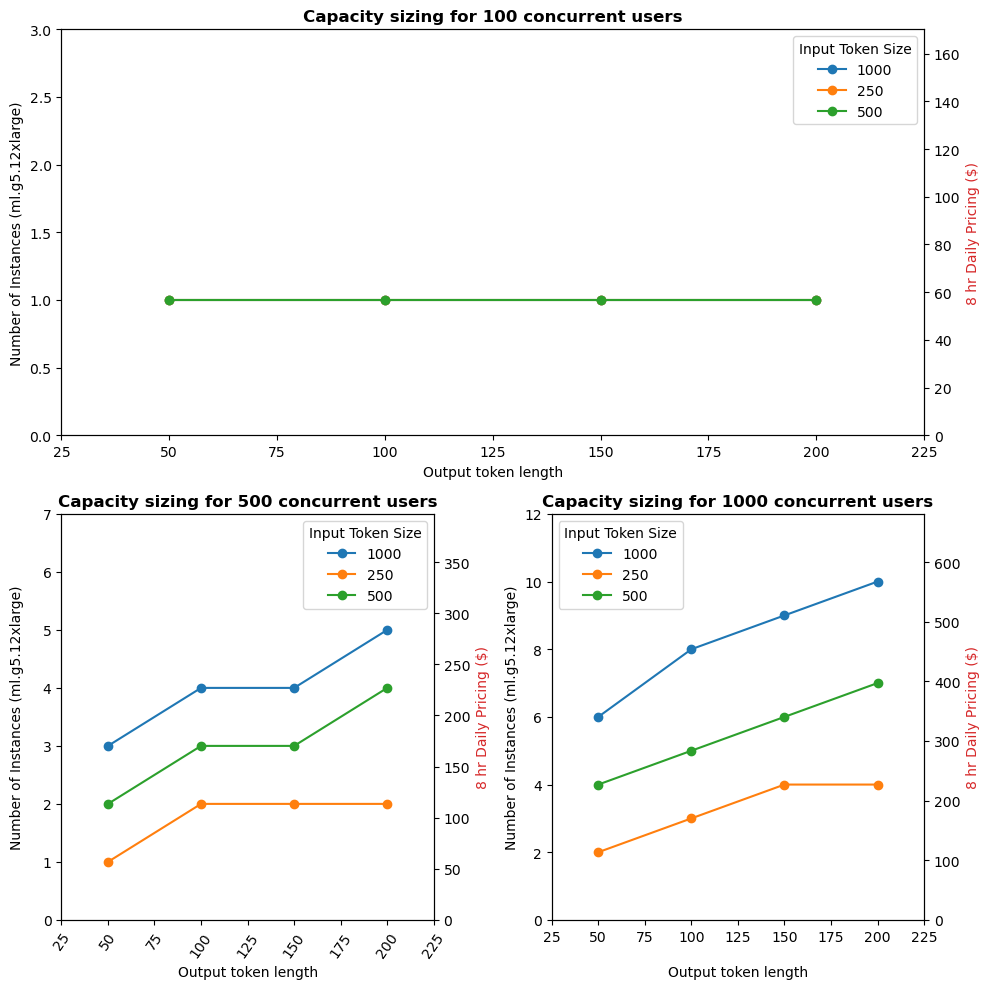

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
# plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(2, 2)

# ax = fig.add_subplot(gs[0, :])
ax = fig.add_subplot(gs[0, :])
ax2 = ax.twinx()
df=dataframe_list[0]
running_hours=8 ## number of hours endpoint would be up and running daily 
for key, group in df.groupby('prompt_size'):  
    ax.plot(group['output_token_length'], group['number_of_instances'], marker='o', label=key)
ax.legend(title='Input Token Size')  
ax.set_xlabel('Output token length')
ax.set_ylabel('Number of Instances (ml.g5.12xlarge)')
plt.title(f'Capacity sizing for {ideal_concurrency[0]} concurrent users',fontweight='bold')
ax.set_xlim(25, 225) 
ax.set_ylim(0, max(df['number_of_instances'])+2) 
color = 'tab:red'
ax2.set_ylabel(f'{running_hours} hr Daily Pricing ($)', color=color) 
ymin, ymax = ax.get_ylim() 
ax2.set_ylim(0, ymax*pricing_per_instance*running_hours) 
for i in range(2):
    ax = fig.add_subplot(gs[1, i])
    df=dataframe_list[i+1]
    ax2 = ax.twinx()
    for key, group in df.groupby('prompt_size'):  
        ax.plot(group['output_token_length'], group['number_of_instances'], marker='o', label=key)
        ax.legend(title='Input Token Size')  
        ax.set_xlabel('Output token length')
        ax.set_ylabel('Number of Instances (ml.g5.12xlarge)')
        plt.title(f'Capacity sizing for {ideal_concurrency[i+1]} concurrent users',fontweight='bold')
        ax.set_xlim(25, 225) 
        ax.set_ylim(0, max(df['number_of_instances'])+2) 
        color = 'tab:red'
        ax2.set_ylabel(f'{running_hours} hr Daily Pricing ($)', color=color)
        ymin, ymax = ax.get_ylim() 
        ax2.set_ylim(0, ymax*pricing_per_instance*running_hours)
        if i == 0:
                for tick in ax.get_xticklabels():
                    tick.set_rotation(55)
fig.align_labels() 
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

### Content Generation Usage Pattern

In [15]:

results_holder2={}

# Different Content Generation payload patterns
token_length=[250, 500,750,1000]

## Tested concurrent limits for the different token output length under 60s
token_length_concurrency_mapping={250:290,
                                  500:130,
                                  750:60,
                                  1000:45}
# Input token is generally small
prompt="""<<SYS>>You are my helpful and obedient assistant that writes books for me. <</SYS>>
[INST]Write a lengthy biography about Alexander The Great. Go very in detail and be comprehensive and touch on every area of his life.[/INST]"""

tok=tokenizer.encode(prompt, return_tensors="pt")[0]
print(f"Token length of prompt {len(tok)}")

for output_token_len in token_length:
    def send_request(prompt):
        time_now=time.time()
        response=predictor.predict({"inputs": prompt,
                          "parameters": {
                "max_new_tokens": output_token_len,
                # "top_p": 0.9,
                # "temperature": 0.6,
                "return_full_text": False,
            }})
        time_later=time.time()
        diff=time_later-time_now
        return diff

    # Create a ThreadPoolExecutor for parallel execution
    with concurrent.futures.ThreadPoolExecutor(max_workers=token_length_concurrency_mapping[output_token_len]) as executor:
        # Submit parallel requests
        futures = [executor.submit(send_request, prompt) for _ in range(token_length_concurrency_mapping[output_token_len])]

        # Wait for all requests to complete
        concurrent.futures.wait(futures)

        # Get the results from completed requests
        results = [future.result() for future in futures]
    results_holder2[output_token_len]=results


Token length of prompt 57


In [17]:
max_inference_time=60 # The maximum time threshold for realtime inference in seconds
ideal_concurrency=[100,500,1000] # number of concurrent users that would be making a single call to the endpoint simultaneously in production

dataframe_list=[]
for concurrency in ideal_concurrency:
    data_holder={
             "output_token_length":[],
             "number_of_instances":[],
             }
    for token_length in results_holder2:    
        request_latencies=results_holder2[token_length]
        avg_request_latency=sum(request_latencies)/len(request_latencies) # average time it took to complete the request for a given usage style pattern
        normalized_concurrency_factor=max_inference_time/avg_request_latency # normalized request latency time to 60secs which is the threshold timeout for sagemaker realtime inference

        # there number of instances required to meet the ideal concurrent users. This is calculated by
        # dividing the ideal concurrent users by the number of concurreny that would max the sagemaker inference timeout threshold (60s)
        number_of_instances_needed=concurrency/(normalized_concurrency_factor*len(request_latencies)) 
        # print(token_length,avg_request_latency,normalized_concurrency, len(request_latencies),number_of_instances_needed)

        data_holder["output_token_length"].append(token_length)
        data_holder["number_of_instances"].append(max(1,round(number_of_instances_needed)))        

    df = pd.DataFrame(data_holder)
    pricing_per_instance = 7.09 # Price per hour for the ml.g5.12xlarge instance. More pricing info at https://aws.amazon.com/sagemaker/pricing/
    # Calculate total pricing for each row  
    running_hours=8 ## number of hours endpoint would be up and running daily 
    df['Hourly Pricing'] = df['number_of_instances'] * pricing_per_instance
    df[f'{running_hours} hours Pricing'] = df['Hourly Pricing'] * running_hours
    dataframe_list.append(df)

In [18]:
for ids, item in enumerate(dataframe_list):
    print(f'Capacity Sizing for {ideal_concurrency[ids]} concurrent users\n{item}\n')

Capacity Sizing for 100 concurrent users
   output_token_length  number_of_instances  Hourly Pricing  8 hours Pricing
0                  250                    1            7.09            56.72
1                  500                    1            7.09            56.72
2                  750                    1            7.09            56.72
3                 1000                    2           14.18           113.44

Capacity Sizing for 500 concurrent users
   output_token_length  number_of_instances  Hourly Pricing  8 hours Pricing
0                  250                    1            7.09            56.72
1                  500                    3           21.27           170.16
2                  750                    6           42.54           340.32
3                 1000                    8           56.72           453.76

Capacity Sizing for 1000 concurrent users
   output_token_length  number_of_instances  Hourly Pricing  8 hours Pricing
0                  250     

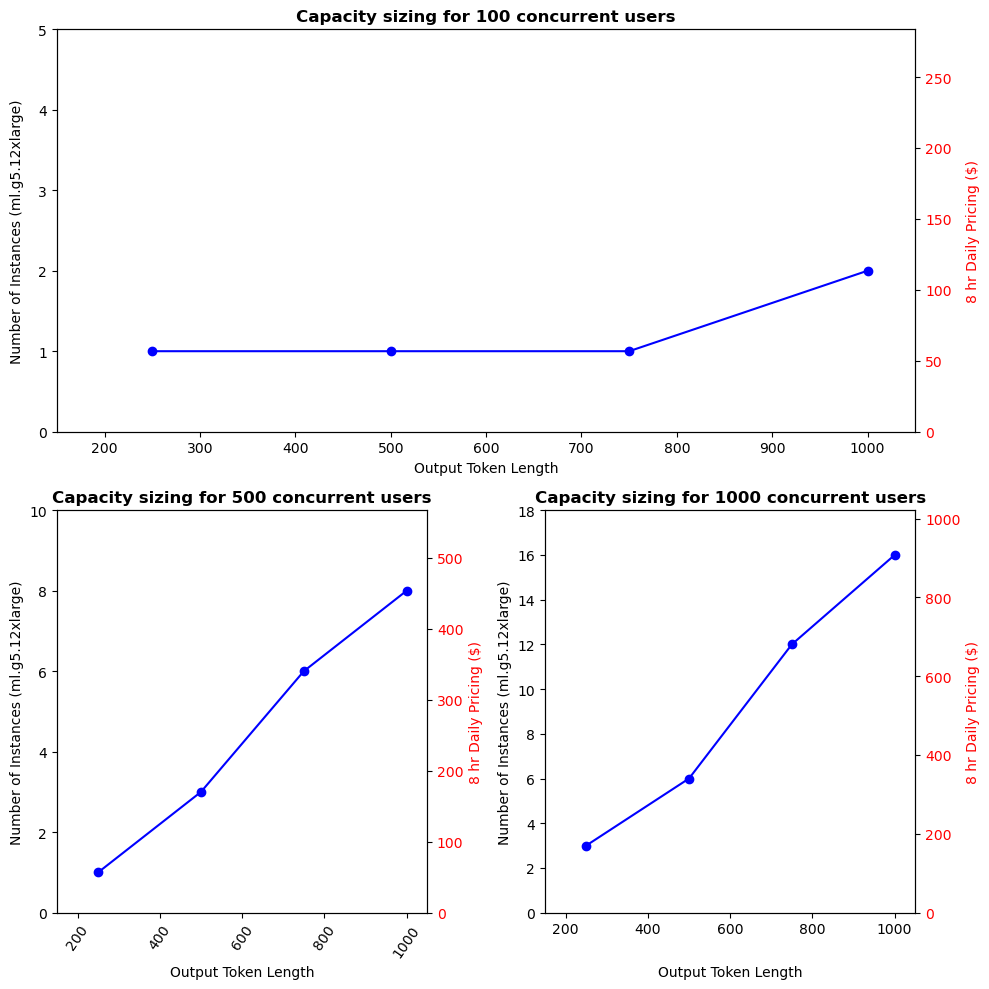

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
# plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(2, 2)

running_hours=8 ## number of hours endpoint would be up and running daily 

ax = fig.add_subplot(gs[0, :])
ax2 = ax.twinx()
df=dataframe_list[0]
ax.plot(df.output_token_length, df.number_of_instances, 'bo-')
ax.set_xlabel('Output Token Length')
ax.set_ylabel('Number of Instances (ml.g5.12xlarge)')
ax.set_ylim(0, max(df['number_of_instances'])+3) 
ax.set_xlim(150, max(df.output_token_length)+50) 
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylabel(f'{running_hours} hr Daily Pricing ($)', color='r')
ymin, ymax = ax.get_ylim() 
ax2.set_ylim(0, ymax*pricing_per_instance*running_hours)
plt.title(f'Capacity sizing for {ideal_concurrency[0]} concurrent users',fontweight='bold')
for i in range(2):
    ax = fig.add_subplot(gs[1, i])
    df=dataframe_list[i+1]
    ax2 = ax.twinx()
    ax.plot(df.output_token_length, df.number_of_instances, 'bo-')
    ax.set_xlabel('Output Token Length')
    ax.set_ylabel('Number of Instances (ml.g5.12xlarge)')
    ax.set_ylim(0, max(df['number_of_instances'])+2) 
    ax.set_xlim(150, max(df.output_token_length)+50) 
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.set_ylabel(f'{running_hours} hr Daily Pricing ($)', color='r')
    ymin, ymax = ax.get_ylim() 
    ax2.set_ylim(0, ymax*pricing_per_instance*running_hours)
    plt.title(f'Capacity sizing for {ideal_concurrency[i+1]} concurrent users',fontweight='bold')
    if i == 0:
        for tick in ax.get_xticklabels():
            tick.set_rotation(55)
fig.align_labels()  # same as fig.align_xlabels(); fig.align_ylabels()
plt.rcParams["figure.figsize"] = (10,10)
plt.show()


## LLama2 13B Quant (4 BIT)

In [22]:
## Initialize sagemaker endpoint
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer
predictor=Predictor(endpoint_name="Llama-2-13B-chat-AWQ-9192028",#endpoint_name_llama_q,
                    serializer=JSONSerializer(),                    
    deserializer=JSONDeserializer(),
                   )

### RAG Usage Pattern

For the quantized models, you able to run the model on an instance with a relatively lower GPU RAM. However, when handling multiple request you would run in Out Of Memory (OOM) or Out of available cache blocks issues. I beleive this is due to the little amount of GPU ram available to batch the input request. I was able to successfully make 10 concurrent calls for the lightest RAG pattern (250 input & 50 output) and 3 for biggest pattern (1000 input and 200 output) before running into OOM errors. Therefore, whereas using the quant models save you on memory requiremnets, it does not scale well on concurent invocations. This issues may be alleviated by playing around with different TGI env variables like MAX_BATCH_PREFILL_TOKENS but would come at a cost of the amount input tokens that can be processed for a single request.

In [23]:
num_parallel_requests = 4  #Number of concurrent users 
results_holder={}

# Different RAG patterns. The dictionary key is the prompt token size and the values are corresponding output token limits
holder={"rag_1000":[50,100,150,200],
        "rag_500":[50,100,150,200],
        "rag_250":[50,100,150,200]
              }
for item in holder:
    results_holder[item]={}
    with open(f"prompt/{item}.txt","r")as f: # different prompt template of various token size stored in local
        prompt=f.read()
    for output_token_len in holder[item]:
        def send_request(prompt):
            time_now=time.time()
            response=predictor.predict({"inputs": prompt,
                              "parameters": {
                    "max_new_tokens": output_token_len,
                    # "top_p": 0.9,
                    # "temperature": 0.6,
                    "return_full_text": False,
                }})
            time_later=time.time()
            diff=time_later-time_now
            return diff

        # Create a ThreadPoolExecutor for parallel execution
        with concurrent.futures.ThreadPoolExecutor(max_workers=num_parallel_requests) as executor:
            # Submit parallel requests
            futures = [executor.submit(send_request, prompt) for _ in range(num_parallel_requests)]

            # Wait for all requests to complete
            concurrent.futures.wait(futures)

            # Get the results from completed requests
            results = [future.result() for future in futures]
        results_holder[item][output_token_len]=results


ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received client error (424) from primary with message "{"error":"Request failed during generation: Server error: CUDA out of memory. Tried to allocate 1.32 GiB. GPU 0 has a total capacty of 22.20 GiB of which 925.12 MiB is free. Process 10758 has 21.29 GiB memory in use. Of the allocated memory 18.29 GiB is allocated by PyTorch, and 1.56 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF","error_type":"generation"}". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/Llama-2-13B-chat-AWQ-9192028 in account 259508681668 for more information.

In [ ]:
max_inference_time=60 # The maximum time threshold for sagemaker realtime inference in seconds
ideal_concurrency=[100,500,1000] # number of concurrent users that would be making a single call to the endpoint simultaneously in production

# data_holder={"prompt_size":[],
#              "output_token_length":[],
#              "number_of_instances":[],
#              }
dataframe_list=[]
for concurrency in ideal_concurrency:
    data_holder={"prompt_size":[],
             "output_token_length":[],
             "number_of_instances":[],
             }
    for prompt_size in results_holder:
        for token_length in results_holder[prompt_size]:
            request_latencies=results_holder[prompt_size][token_length]
            avg_request_latency=sum(request_latencies)/len(request_latencies) # average time it took to complete the request for a given usage style combination
            normalized_concurrency_factor=max_inference_time/avg_request_latency # normalized average request latency time to 60secs which is the threshold timeout for sagemaker realtime inference

            # the number of instances required to meet the ideal concurrent users. This is calculated by
            # dividing the ideal concurrent users by the number of concurrent users that would max the sagemaker inference response timeout threshold (60s)
            number_of_instances_needed=concurrency/(normalized_concurrency_factor*num_parallel_requests) 
            data_holder["prompt_size"].append(prompt_size.split('_')[-1])
            data_holder["output_token_length"].append(token_length)
            data_holder["number_of_instances"].append(max(1,round(number_of_instances_needed)))        

    df = pd.DataFrame(data_holder)
    pricing_per_instance = 1.515 # Price per hour for the ml.g5.2xlarge instance. More pricing info at https://aws.amazon.com/sagemaker/pricing/
    # Calculate total pricing for each row  
    df['Hourly Pricing'] = df['number_of_instances'] * pricing_per_instance
    # df['Daily Pricing'] = df['Hourly Pricing'] * 24
    dataframe_list.append(df)

In [ ]:
for ids, item in enumerate(dataframe_list):
    print(f'Capacity Sizing for {ideal_concurrency[ids]} concurrent users\n{item}\n')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
# plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(2, 2)

# ax = fig.add_subplot(gs[0, :])
ax = fig.add_subplot(gs[0, :])
ax2 = ax.twinx()
df=dataframe_list[0]
running_hours=8 ## number of hours endpoint would be up and running daily 
for key, group in df.groupby('prompt_size'):  
    ax.plot(group['output_token_length'], group['number_of_instances'], marker='o', label=key)
ax.legend(title='Input Token Size')  
ax.set_xlabel('Output token length')
ax.set_ylabel('Number of Instances (ml.g5.2xlarge)')
plt.title(f'Capacity sizing for {ideal_concurrency[0]} concurrent users',fontweight='bold')
ax.set_xlim(25, 225) 
ax.set_ylim(0, max(df['number_of_instances'])+2) 
color = 'tab:red'
ax2.set_ylabel(f'{running_hours} hr Daily Pricing ($)', color=color) 
ymin, ymax = ax.get_ylim() 
ax2.set_ylim(0, ymax*pricing_per_instance*running_hours) 
for i in range(2):
    ax = fig.add_subplot(gs[1, i])
    df=dataframe_list[i+1]
    ax2 = ax.twinx()
    for key, group in df.groupby('prompt_size'):  
        ax.plot(group['output_token_length'], group['number_of_instances'], marker='o', label=key)
        ax.legend(title='Input Token Size')  
        ax.set_xlabel('Output token length')
        ax.set_ylabel('Number of Instances (ml.g5.2xlarge)')
        plt.title(f'Capacity sizing for {ideal_concurrency[i+1]} concurrent users',fontweight='bold')
        ax.set_xlim(25, 225) 
        ax.set_ylim(0, max(df['number_of_instances'])+2) 
        color = 'tab:red'
        ax2.set_ylabel(f'{running_hours} hr Daily Pricing ($)', color=color)
        ymin, ymax = ax.get_ylim() 
        ax2.set_ylim(0, ymax*pricing_per_instance*running_hours)
        if i == 0:
                for tick in ax.get_xticklabels():
                    tick.set_rotation(55)
fig.align_labels() 
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

#### Content Generation Usage Pattern

Same issue with the RAG pattern style in terms of OOM or Out of available cache blocks. I was able to get 20 concurrent request for 250 output length and 10 for 1000 output length

In [30]:

results_holder2={}

# Different Content Generation payload patterns
token_length=[250, 500,750,1000]

## Tested concurrent limits for the different token output length under 60s
token_length_concurrency_mapping={250:35,
                                  500:20,
                                  750:15,
                                  1000:15}
# Input token is generally small
prompt="""<<SYS>>You are my helpful and obedient assistant that writes books for me. <</SYS>>
[INST]Write a lengthy biography about Alexander The Great. Go very in detail and be comprehensive and touch on every area of his life.[/INST]"""

tok=tokenizer.encode(prompt, return_tensors="pt")[0]
print(f"Token length of prompt {len(tok)}")

for output_token_len in token_length:
    def send_request(prompt):
        time_now=time.time()
        response=predictor.predict({"inputs": prompt,
                          "parameters": {
                "max_new_tokens": output_token_len,
                # "top_p": 0.9,
                # "temperature": 0.6,
                "return_full_text": False,
            }})
        time_later=time.time()
        diff=time_later-time_now
        return diff

    # Create a ThreadPoolExecutor for parallel execution
    with concurrent.futures.ThreadPoolExecutor(max_workers=token_length_concurrency_mapping[output_token_len]) as executor:
        # Submit parallel requests
        futures = [executor.submit(send_request, prompt) for _ in range(token_length_concurrency_mapping[output_token_len])]

        # Wait for all requests to complete
        concurrent.futures.wait(futures)

        # Get the results from completed requests
        results = [future.result() for future in futures]
    results_holder2[output_token_len]=results


Token length of prompt 57


ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received client error (424) from primary with message "{"error":"Request failed during generation: Server error: Out of available cache blocks: asked 480, only 450 free blocks","error_type":"generation"}". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/Llama-2-13B-chat-AWQ-9192028 in account 259508681668 for more information.

In [29]:
results_holder2

{}

In [ ]:
max_inference_time=60 # The maximum time threshold for realtime inference in seconds
ideal_concurrency=[100,500,1000] # number of concurrent users that would be making a single call to the endpoint simultaneously in production

dataframe_list=[]
for concurrency in ideal_concurrency:
    data_holder={
             "output_token_length":[],
             "number_of_instances":[],
             }
    for token_length in results_holder2:    
        request_latencies=results_holder2[token_length]
        avg_request_latency=sum(request_latencies)/len(request_latencies) # average time it took to complete the request for a given usage style pattern
        normalized_concurrency_factor=max_inference_time/avg_request_latency # normalized request latency time to 60secs which is the threshold timeout for sagemaker realtime inference

        # there number of instances required to meet the ideal concurrent users. This is calculated by
        # dividing the ideal concurrent users by the number of concurreny that would max the sagemaker inference timeout threshold (60s)
        number_of_instances_needed=concurrency/(normalized_concurrency_factor*len(request_latencies)) 
        # print(token_length,avg_request_latency,normalized_concurrency, len(request_latencies),number_of_instances_needed)

        data_holder["output_token_length"].append(token_length)
        data_holder["number_of_instances"].append(max(1,round(number_of_instances_needed)))        

    df = pd.DataFrame(data_holder)
    pricing_per_instance = 1.515 # Price per hour for the ml.g5.2xlarge instance. More pricing info at https://aws.amazon.com/sagemaker/pricing/
    # Calculate total pricing for each row  
    running_hours=8 ## number of hours endpoint would be up and running daily 
    df['Hourly Pricing'] = df['number_of_instances'] * pricing_per_instance
    df[f'{running_hours} hours Pricing'] = df['Hourly Pricing'] * running_hours
    dataframe_list.append(df)

In [ ]:
for ids, item in enumerate(dataframe_list):
    print(f'Capacity Sizing for {ideal_concurrency[ids]} concurrent users\n{item}\n')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
# plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(2, 2)

running_hours=8 ## number of hours endpoint would be up and running daily 

ax = fig.add_subplot(gs[0, :])
ax2 = ax.twinx()
df=dataframe_list[0]
ax.plot(df.output_token_length, df.number_of_instances, 'bo-')
ax.set_xlabel('Output Token Length')
ax.set_ylabel('Number of Instances (ml.g5.2xlarge)')
ax.set_ylim(0, max(df['number_of_instances'])+3) 
ax.set_xlim(150, max(df.output_token_length)+50) 
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylabel(f'{running_hours} hr Daily Pricing ($)', color='r')
ymin, ymax = ax.get_ylim() 
ax2.set_ylim(0, ymax*pricing_per_instance*running_hours)
plt.title(f'Capacity sizing for {ideal_concurrency[0]} concurrent users',fontweight='bold')
for i in range(2):
    ax = fig.add_subplot(gs[1, i])
    df=dataframe_list[i+1]
    ax2 = ax.twinx()
    ax.plot(df.output_token_length, df.number_of_instances, 'bo-')
    ax.set_xlabel('Output Token Length')
    ax.set_ylabel('Number of Instances (ml.g5.2xlarge)')
    ax.set_ylim(0, max(df['number_of_instances'])+2) 
    ax.set_xlim(150, max(df.output_token_length)+50) 
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.set_ylabel(f'{running_hours} hr Daily Pricing ($)', color='r')
    ymin, ymax = ax.get_ylim() 
    ax2.set_ylim(0, ymax*pricing_per_instance*running_hours)
    plt.title(f'Capacity sizing for {ideal_concurrency[i+1]} concurrent users',fontweight='bold')
    if i == 0:
        for tick in ax.get_xticklabels():
            tick.set_rotation(55)
fig.align_labels()  # same as fig.align_xlabels(); fig.align_ylabels()
plt.rcParams["figure.figsize"] = (10,10)
plt.show()
